In [1]:
import os
import sys
os.environ['QT_QPA_PLATFORM'] = 'offscreen'

from osgeo import ogr
from qgis.core import *
from qgis.gui import *
from qgis import processing

from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice

qgs = QgsApplication([], False)
qgs.initQgis()
print(QgsApplication.showSettings())

Application state:
QGIS_PREFIX_PATH env var:		C:/OSGEO4~1/apps/qgis
Prefix:		C:/OSGEO4~1/apps/qgis
Plugin Path:		C:/OSGEO4~1/apps/qgis/plugins
Package Data Path:	C:/OSGEO4~1/apps/qgis/.
Active Theme Name:	
Active Theme Path:	C:/OSGEO4~1/apps/qgis/./resources/themes\\icons/
Default Theme Path:	:/images/themes/default/
SVG Search Paths:	C:/OSGEO4~1/apps/qgis/./svg/
		C:/Users/bruno/AppData/Roaming/python3\profiles\default/svg/
User DB Path:	C:/OSGEO4~1/apps/qgis/./resources/qgis.db
Auth DB Path:	C:/Users/bruno/AppData/Roaming/python3\profiles\default/qgis-auth.db



In [52]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/jgrocha/covid-pt/master/situacao_epidemiologica.csv")#, nrows=55)
df = df.sort_values(by=['id'])
df = df.set_index('id')

#df.tail()
pd.set_option('display.max_rows', df.shape[0]+1)
print(df)

                                                  url data_relatorio  \
id                                                                     
1   https://covid19.min-saude.pt/wp-content/upload...     2020-03-03   
2   https://covid19.min-saude.pt/wp-content/upload...     2020-03-04   
3   https://covid19.min-saude.pt/wp-content/upload...     2020-03-05   
4   https://covid19.min-saude.pt/wp-content/upload...     2020-03-06   
5   https://covid19.min-saude.pt/wp-content/upload...     2020-03-07   
6   https://covid19.min-saude.pt/wp-content/upload...     2020-03-08   
7   https://covid19.min-saude.pt/wp-content/upload...     2020-03-09   
8   https://covid19.min-saude.pt/wp-content/upload...     2020-03-10   
9   https://covid19.min-saude.pt/wp-content/upload...     2020-03-11   
10  https://covid19.min-saude.pt/wp-content/upload...     2020-03-12   
11  https://covid19.min-saude.pt/wp-content/upload...     2020-03-13   
12  https://covid19.min-saude.pt/wp-content/upload...     2020-0

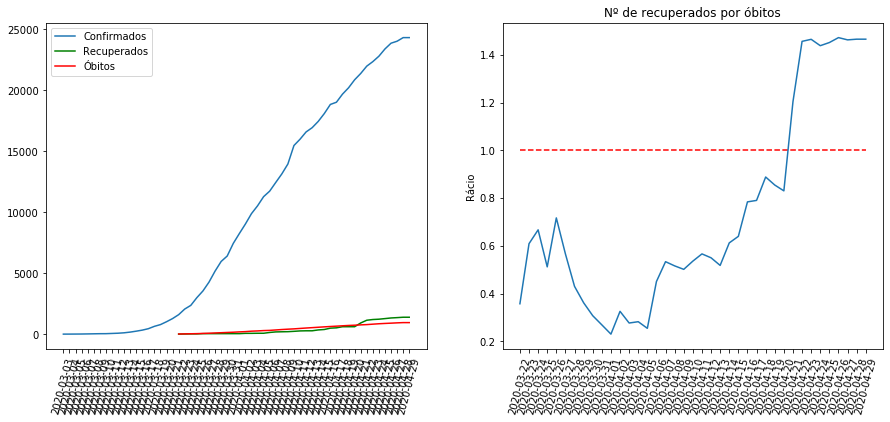

In [115]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

dates = df['data_relatorio'].to_numpy()
recuperados = df['recuperados'].to_numpy()
obitos = df['obitos'].to_numpy()
confirmados = df['confirmados'].to_numpy()

start = 0
for i in range(0, dates.size):
    if obitos[i] > 0 and recuperados[i] > 0:
        start = i
        break

ratio = recuperados[start:] / obitos[start:]

fig, (sub1, sub2) = plt.subplots(1, 2,figsize=(15,6))

sub1.plot(dates, confirmados)
sub1.plot(dates[start:], recuperados[start:], 'g')
sub1.plot(dates[start:], obitos[start:], 'r')
sub1.legend(['Confirmados', 'Recuperados', 'Óbitos'])
#sub1.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
#sub1.xaxis.set_major_locator(mdates.DayLocator(interval=5))
#fig.autofmt_xdate()

sub2.set_title("Nº de recuperados por óbitos")
sub2.plot(dates[start:], ratio)
sub2.hlines(1, dates[start], dates[dates.size - 1], linestyles='dashed', colors='red')
sub2.set(ylabel="Rácio")

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=75)

plt.show()